# Notebook de choix de modèle de classification binaire

Notebook ChatGPT : 

**Modèles à comparer**

a) Modèles classiques (baseline)

* Logistic Regression
* Decision Tree
* Random Forest
* Gradient Boosting (XGBoost / LightGBM / CatBoost)
* Support Vector Machine (SVM) avec kernel linéaire et RBF)

b) Modèles linéaires avancés

* Ridge / Lasso / ElasticNet
* Stochastic Gradient Descent (SGDClassifier)

c) Réseaux de neurones simples

* MLP (1 à 3 couches cachées)

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import data_preparation


In [7]:
df = pd.read_csv("./data/train.csv", sep=",")

X, _ = data_preparation.prepare_df(df.drop(columns=["Survived", "PassengerId"]))
y = df.loc[:, "Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Optimisation sur l'ensemble des modèles

In [9]:
# Normalisation pour les modèles linéaires et SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionnaire des modèles
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "SVM": SVC(),
    "Ridge": RidgeClassifier(),
    "Lasso": SGDClassifier(loss='squared_hinge', penalty='l1', max_iter=1000),  # Lasso adapté pour classification
    "ElasticNet": SGDClassifier(loss='squared_hinge', penalty='elasticnet', max_iter=1000),
    "SGDClassifier": SGDClassifier(max_iter=1000, tol=1e-3),
    "MLP": MLPClassifier(max_iter=1000)
}

# Evaluation
results = {}
for name, model in models.items():
    # Choisir si on utilise les features normalisées
    if name in ["Logistic Regression", "SVM", "Ridge", "Lasso", "ElasticNet", "SGDClassifier", "MLP"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc


c:\Users\mathi\dev\titanic\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:28:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\Users\mathi\dev\titanic\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [10]:
for name, acc in results.items():
    print(f"{name}: Accuracy = {acc:.4f}")


Logistic Regression: Accuracy = 0.8156
Decision Tree: Accuracy = 0.7709
Random Forest: Accuracy = 0.8268
XGBoost: Accuracy = 0.8212
LightGBM: Accuracy = 0.8101
CatBoost: Accuracy = 0.8268
SVM: Accuracy = 0.8156
Ridge: Accuracy = 0.7877
Lasso: Accuracy = 0.6425
ElasticNet: Accuracy = 0.6760
SGDClassifier: Accuracy = 0.7654
MLP: Accuracy = 0.8492


## Optimisation sur les paramètres

In [27]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform, randint
import json

In [19]:
def extract_results_from_rand_search(rand_search):
    results = {
        "best_params": rand_search.best_params_,
        "best_score": float(rand_search.best_score_),  # convertir en float pour JSON
        "best_estimator": str(rand_search.best_estimator_),  # ou str() pour une description
        "cv_results": {}
    }

    # Extraire cv_results_
    cv_results = rand_search.cv_results_
    for key, value in cv_results.items():
        # Convertir les arrays numpy en liste pour JSON
        if isinstance(value, np.ndarray):
            results["cv_results"][key] = value.tolist()
        else:
            results["cv_results"][key] = value
    
    return results

### RandomSearch

#### a. MLP

In [ ]:
# 4min 06.3
mlp = MLPClassifier(max_iter=1000, random_state=42)

mlp_param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (100,50), (50,50,25)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.01),  # régularisation
    'learning_rate': ['constant', 'adaptive']
}

mlp_rand = RandomizedSearchCV(
    mlp, mlp_param_dist, n_iter=30, cv=3, scoring='accuracy', n_jobs=-1, random_state=42
)
mlp_rand.fit(X_train_scaled, y_train)
print("MLP Best params:", mlp_rand.best_params_)
print("MLP Best CV accuracy:", mlp_rand.best_score_)

MLP Best params: {'activation': 'relu', 'alpha': np.float64(0.003062735057040824), 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
MLP Best CV accuracy: 0.8216560885957759


In [ ]:
with open("./data/MLP_randomized_search_results.json", "w") as f:
    json.dump(extract_results_from_rand_search(mlp_rand), f, indent=4)

#### b. Random Forest

In [21]:
rf = RandomForestClassifier(random_state=42)

rf_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_rand = RandomizedSearchCV(rf, rf_param_dist, n_iter=30, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
rf_rand.fit(X_train, y_train)
print("RF Best params:", rf_rand.best_params_)
print("RF Best CV accuracy:", rf_rand.best_score_)

RF Best params: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 140}
RF Best CV accuracy: 0.8286529801794136


In [22]:
with open("./data/RF_randomized_search_results.json", "w") as f:
    json.dump(extract_results_from_rand_search(rf_rand), f, indent=4)

#### c. XGBoost

In [23]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.1),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

xgb_rand = RandomizedSearchCV(xgb_model, xgb_param_dist, n_iter=30, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
xgb_rand.fit(X_train, y_train)
print("XGBoost Best params:", xgb_rand.best_params_)
print("XGBoost Best CV accuracy:", xgb_rand.best_score_)

XGBoost Best params: {'colsample_bytree': np.float64(0.8834959481464842), 'learning_rate': np.float64(0.01070663052197174), 'max_depth': 3, 'n_estimators': 148, 'subsample': np.float64(0.8574323980775167)}
XGBoost Best CV accuracy: 0.8328901180725454


c:\Users\mathi\dev\titanic\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:57:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
with open("./data/XGBoost_randomized_search_results.json", "w") as f:
    json.dump(extract_results_from_rand_search(xgb_rand), f, indent=4)

#### d. CatBoost

In [25]:
cat_model = CatBoostClassifier(verbose=0, random_state=42)

cat_param_dist = {
    'iterations': randint(200, 1000),
    'depth': randint(4, 8),
    'learning_rate': uniform(0.01, 0.1),
    'l2_leaf_reg': randint(1, 5),
    'border_count': [32, 50, 100]
}

cat_rand = RandomizedSearchCV(cat_model, cat_param_dist, n_iter=30, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
cat_rand.fit(X_train, y_train)
print("CatBoost Best params:", cat_rand.best_params_)
print("CatBoost Best CV accuracy:", cat_rand.best_score_)

CatBoost Best params: {'border_count': 100, 'depth': 4, 'iterations': 204, 'l2_leaf_reg': 2, 'learning_rate': np.float64(0.033598491974895575)}
CatBoost Best CV accuracy: 0.8328723894621138


In [26]:
with open("./data/CatBoost_randomized_search_results.json", "w") as f:
    json.dump(extract_results_from_rand_search(cat_rand), f, indent=4)

### RandomSearch Analysis I

In [33]:
xgb_rand_dict = extract_results_from_rand_search(xgb_rand)

In [ ]:
xgb_rand_cv_results = pd.DataFrame(xgb_rand_dict["cv_results"])

In [44]:
xgb_rand_cv_results.sort_values(by="mean_test_score", ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,0.069888,0.003167,0.006527,0.000324,0.883496,0.010707,3,148,0.857432,"{'colsample_bytree': 0.8834959481464842, 'lear...",0.815126,0.852321,0.831224,0.832890,0.015230,1
9,0.216961,0.003701,0.009569,0.000768,0.769268,0.034103,6,363,0.710317,"{'colsample_bytree': 0.7692681476866446, 'lear...",0.823529,0.822785,0.831224,0.825846,0.003815,2
20,0.104334,0.008608,0.009676,0.002663,0.918882,0.073756,5,134,0.841664,"{'colsample_bytree': 0.9188818535014192, 'lear...",0.819328,0.818565,0.831224,0.823039,0.005796,3
21,0.064644,0.003919,0.006998,0.001489,0.735878,0.081324,3,104,0.868383,"{'colsample_bytree': 0.7358782737814905, 'lear...",0.823529,0.814346,0.822785,0.820220,0.004165,4
3,0.250265,0.005459,0.009114,0.000004,0.981566,0.010078,6,376,0.885244,"{'colsample_bytree': 0.981565812704725, 'learn...",0.806723,0.818565,0.831224,0.818837,0.010004,5


<Axes: >

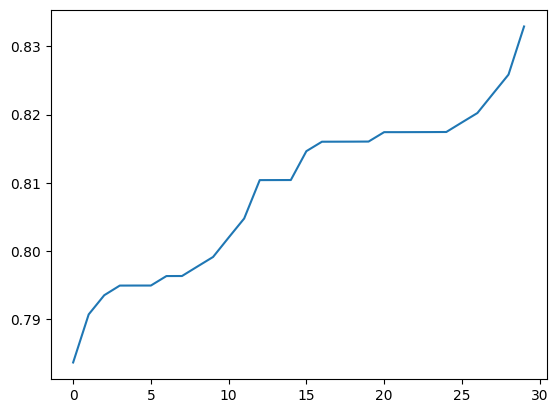

In [46]:
xgb_rand_cv_results["mean_test_score"].sort_values().reset_index(drop=True).plot()

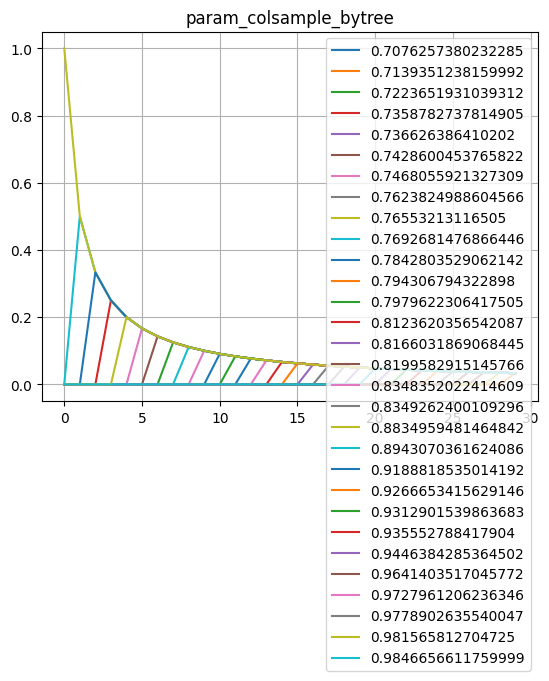

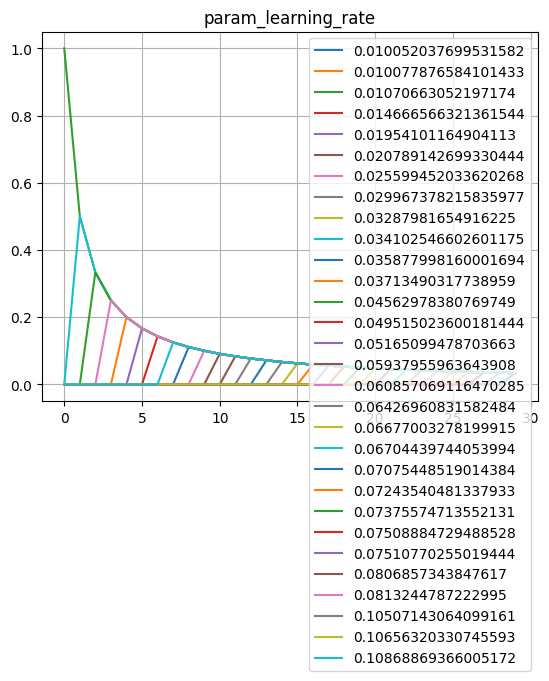

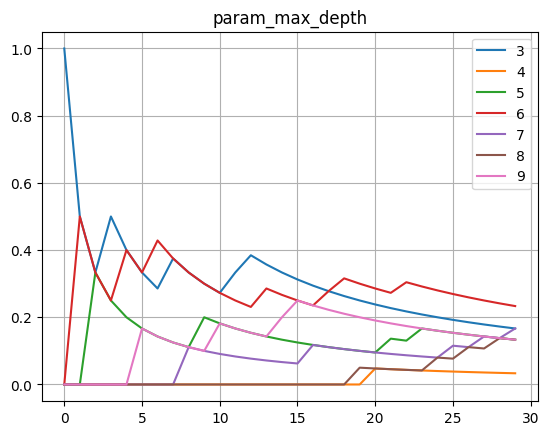

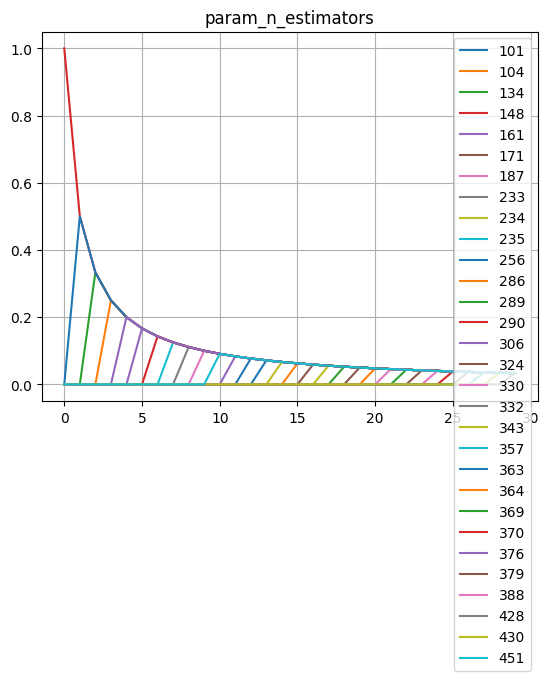

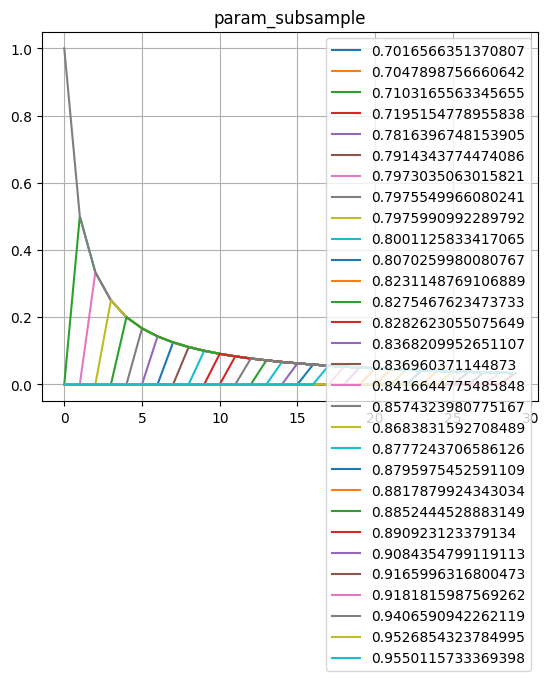

In [99]:
param_cols = [col for col in xgb_rand_cv_results.columns if "param_" in col]

for param in param_cols:
    unique_vals = xgb_rand_cv_results[param].sort_values().unique()
    unique_vals_position = {val: [] for val in unique_vals}

    n = xgb_rand_cv_results.shape[0]

    for k in range(1, n+1):
        subset = (
            xgb_rand_cv_results
            .sort_values(by="mean_test_score", ascending=False)
            .iloc[:k]
            .loc[:, param]
        )

        stats = subset.value_counts()

        for key in unique_vals_position.keys():
            if key in stats:
                unique_vals_position[key].append(stats.loc[key])
            else:
                unique_vals_position[key].append(0)
    
    for key, list_vals in unique_vals_position.items():
        plt.plot([list_vals[k]/(k+1) for k in range(len(list_vals))], label=key)

    plt.title(param)
    plt.legend()
    plt.grid()
    plt.show()

In [97]:
unique_vals = xgb_rand_cv_results[param].sort_values().unique()
unique_vals_position = {val: [] for val in unique_vals}

n = xgb_rand_cv_results.shape[0]

for k in range(1, n+1):
    subset = (
        xgb_rand_cv_results
        .sort_values(by="mean_test_score", ascending=False)
        .iloc[:k]
        .loc[:, param]
    )

    stats = subset.value_counts()

    for key in unique_vals_position.keys():
        if key in stats:
            unique_vals_position[key].append(stats.loc[key])
        else:
            unique_vals_position[key].append(0)

for key, list_vals in unique_vals_position.items():
    plt.plot([list_vals[k]/(k+1) for k in range(len(list_vals))], label=key)

plt.title(param)
plt.legend()
plt.grid()
plt.show()

TypeError: '<' not supported between instances of 'dict' and 'dict'

### RandomSearch Analysis II

In [107]:
xgb_rand_cv_results = pd.DataFrame(extract_results_from_rand_search(xgb_rand)["cv_results"])

On va faire un bootstrapping pour la sélection d'un intervalle de confiance à 95% en pondérant par l'accuracy.

In [197]:
a, b = xgb_rand_cv_results["mean_test_score"].min(), xgb_rand_cv_results["mean_test_score"].max()
xgb_rand_cv_results["mean_test_score_min_max"] = (xgb_rand_cv_results["mean_test_score"] - a) / (b-a)
xgb_rand_cv_results["mean_test_score_exp"] = np.exp(3*xgb_rand_cv_results["mean_test_score_min_max"] - 1)

In [141]:
M = xgb_rand_cv_results["mean_test_score_exp"].sum()
score_cumul_list = [xgb_rand_cv_results["mean_test_score_exp"].iloc[:k].sum() for k in range(30)]

In [170]:
X = np.random.uniform(0, M, 10000)
P = np.searchsorted(score_cumul_list, X) - 1

In [171]:
np.unique(P)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

(array([ 119.,  429.,  106.,  466., 1129.,  469.,  390.,   48.,  137.,
         744.,  403.,  123.,  229.,  108.,  292.,  409.,  465.,  145.,
         308.,  438.,  578.,  527.,  415.,  416.,  112.,  291.,   85.,
          68.,  156.,  395.]),
 array([ 0.        ,  0.96666667,  1.93333333,  2.9       ,  3.86666667,
         4.83333333,  5.8       ,  6.76666667,  7.73333333,  8.7       ,
         9.66666667, 10.63333333, 11.6       , 12.56666667, 13.53333333,
        14.5       , 15.46666667, 16.43333333, 17.4       , 18.36666667,
        19.33333333, 20.3       , 21.26666667, 22.23333333, 23.2       ,
        24.16666667, 25.13333333, 26.1       , 27.06666667, 28.03333333,
        29.        ]),
 <BarContainer object of 30 artists>)

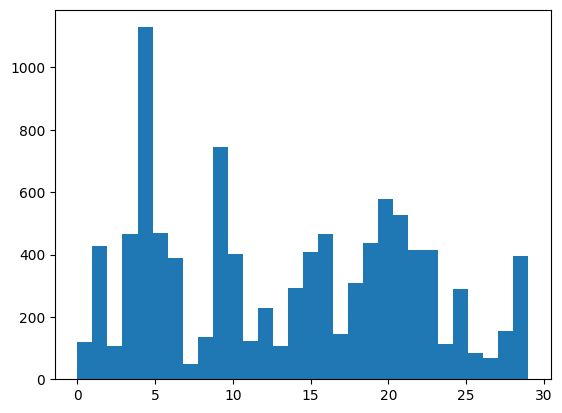

In [172]:
plt.hist(P, bins=30)

In [193]:
vals, counts = np.unique(P, return_counts=True)
threshold = np.quantile(counts, q=0.75)
selection_index = vals[counts > threshold]

In [ ]:
selection_mask = xgb_rand_cv_results.index.isin(selected_index)
selection_subset = xgb_rand_cv_results[selection_mask]["mean_test_score_exp"]

M = selection_subset.sum()

score_cumul_list = [
    selection_subset.iloc[:k].sum()
    for k in range(30)
]

In [228]:
score_cumul_list = []
for k in range(30):
    if k in selected_index:
        # print(k, k in selected_index, selected_index)
        score_cumul_list.append(selection_subset.iloc[:k].sum())
    elif (selected_index < k).sum() == 0:
        # print(k, k in selected_index, 0)
        score_cumul_list.append(0)
    else:
        # print(k, k in selected_index, selected_index[selected_index < k].max())
        j = selected_index[selected_index < k].max()
        score_cumul_list.append(selection_subset.iloc[:j].sum())


In [234]:
for k in range(30):
    print(k, [float(x) for x in score_cumul_list][k], [float(selection_subset.iloc[:k].sum()) for k in range(30)][k])
    # print([float(selection_subset.iloc[:k].sum()) for k in range(30)][k])

0 0.0 0.0
1 0.0 2.877217388320145
2 0.0 5.755471923179383
3 8.635801872827852 8.635801872827852
4 11.771839545323525 11.771839545323525
5 15.183825693617313 15.183825693617313
6 15.183825693617313 19.235811615287727
7 15.183825693617313 24.04437730724152
8 15.183825693617313 31.43343340617217
9 31.43343340617217 31.43343340617217
10 31.43343340617217 31.43343340617217
11 31.43343340617217 31.43343340617217
12 31.43343340617217 31.43343340617217
13 31.43343340617217 31.43343340617217
14 31.43343340617217 31.43343340617217
15 31.43343340617217 31.43343340617217
16 31.43343340617217 31.43343340617217
17 31.43343340617217 31.43343340617217
18 31.43343340617217 31.43343340617217
19 31.43343340617217 31.43343340617217
20 31.43343340617217 31.43343340617217
21 31.43343340617217 31.43343340617217
22 31.43343340617217 31.43343340617217
23 31.43343340617217 31.43343340617217
24 31.43343340617217 31.43343340617217
25 31.43343340617217 31.43343340617217
26 31.43343340617217 31.43343340617217
27 31

In [206]:
param_n_estimators_bootstrapping = (
    xgb_rand_cv_results["param_n_estimators"]
    .iloc[P]
    .value_counts()
    .sort_index()
)

X = param_n_estimators_bootstrapping.index
y = param_n_estimators_bootstrapping.to_list()

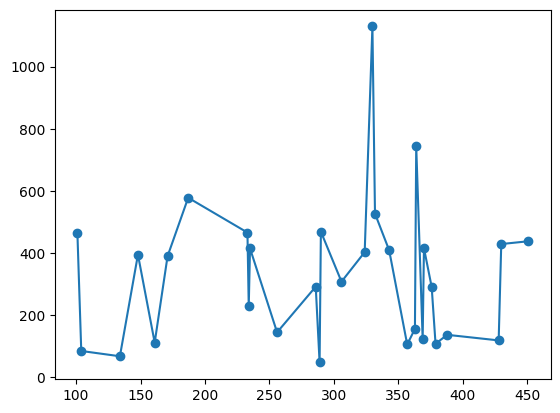

In [207]:
plt.plot(X, y, "-o")

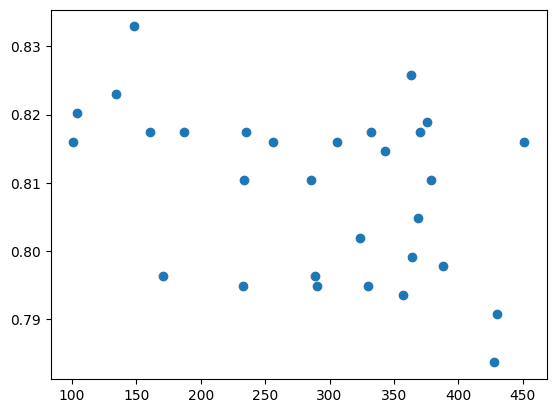

In [166]:
plt.plot(
    xgb_rand_cv_results["param_n_estimators"],
    xgb_rand_cv_results["mean_test_score"],
    "o"
)

### RandomSearch Analysis III

In [168]:
xgb_rand_cv_results = pd.DataFrame(extract_results_from_rand_search(xgb_rand)["cv_results"]).sort_values("mean_test_score")
cat_rand_cv_results = pd.DataFrame(extract_results_from_rand_search(cat_rand)["cv_results"]).sort_values("mean_test_score")

### Grid Search

In [28]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_param_grid = {
    'n_estimators': [120, 140, 160, 180],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.008, 0.010, 0.012, 0.015],
    'subsample': [0.857],
    'colsample_bytree': [0.8, 0.88, 0.95]
}

xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
print("XGBoost Best params:", xgb_grid.best_params_)
print("XGBoost Best accuracy:", xgb_grid.best_score_)

XGBoost Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.015, 'max_depth': 3, 'n_estimators': 160, 'subsample': 0.857}
XGBoost Best accuracy: 0.8356643356643356


c:\Users\mathi\dev\titanic\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:13:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [30]:
with open("./data/XGBoost_grid_search_results.json", "w") as f:
    json.dump(extract_results_from_rand_search(xgb_grid), f, indent=4)

In [29]:
cat_model = CatBoostClassifier(verbose=0, random_state=42)

cat_param_grid = {
    'iterations': [180, 200, 220, 250],
    'depth': [4, 5, 6],
    'learning_rate': [0.025, 0.030, 0.035, 0.040],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [100]
}

cat_grid = GridSearchCV(cat_model, cat_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
cat_grid.fit(X_train, y_train)
print("CatBoost Best params:", cat_grid.best_params_)
print("CatBoost Best accuracy:", cat_grid.best_score_)

CatBoost Best params: {'border_count': 100, 'depth': 5, 'iterations': 220, 'l2_leaf_reg': 3, 'learning_rate': 0.03}
CatBoost Best accuracy: 0.8342558849601103


In [31]:
with open("./data/CatBoost_grid_search_results.json", "w") as f:
    json.dump(extract_results_from_rand_search(cat_grid), f, indent=4)